In [70]:
import os 
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import skimage
from skimage import io
from pathlib import Path
import re
from skimage import exposure
import h5py
import cv2 as cv
from skimage.util import img_as_ubyte
from skimage import exposure
from scipy import signal


In [71]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / 'data'
figure_dir = p_dir / 'figures'

In [72]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import tof-sims data

In [73]:
from skimage.transform import resize
import matplotlib.gridspec as gridspec
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=34)

h5_data_dir = p_dir / 'data' / 'h5'

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f'{experiment}.hdf5', 'r') as f:
        imgs = f[name][:]
        labels = list(f[name].attrs['labels'])
        fov = f[name].attrs['fov']
    return imgs, labels, fov

def get_NN(data, n):
    fit = NearestNeighbors(n_neighbors=n).fit(data)
    distances, indices = fit.kneighbors(data)

    return distances, indices

def filter_img_knn(img, n=25, th=3.5):
    # Get avg distances per positive expressed pixels
    x, y = np.where(img > 0)
    values = img[x,y]
    
    data = np.column_stack((x,y))
    distances, indices = get_NN(data, n)
    # avg_dist = np.average(distances, axis=1, weights=values[indices])
    avg_dist = np.average(distances, axis=1)
        
    filter_ind = avg_dist > th
    unique, counts = np.unique(filter_ind, return_counts=True)
    print(unique, counts)
    x_fil = x[filter_ind]
    y_fil = y[filter_ind]

    img_fil = img.copy()
    img_fil[x_fil, y_fil] = 0
    
    return img_fil

def contrast(img):
    p2, p98 = np.percentile(img, (0.1, 99.9))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255))
    img = img.astype(np.uint8)
    return img

def get_imgs_index(imgs, index_list):
    
    imgs_subset = imgs[index_list, :,:]
    img_combined = np.sum(imgs_subset, axis=0)
    return img_combined

def get_mass(file):
    labels = ['total', 'rest']
    with open(file) as infile:
        next(infile)
        for line in infile:
            mass = float(line.split("\t")[1])
            mass = np.round(mass, 1)
            labels.append(mass)
    return labels

In [74]:
masses = get_mass(data_dir / 'metadata' / 'peak.TXT')

In [75]:
experiment = 'endometrium'

ts_data_dir = p_dir / 'data' / 'tof-sims' / experiment
datasets = listdir(ts_data_dir)
datasets = [dataset for dataset in datasets if 'auto' not in dataset]

L11_1
[False  True] [255980   5357]
L11_2
[False  True] [254827   6153]
L11_3
[False  True] [256831   4667]
L128_1
[False  True] [253116   6675]
L128_2
[False  True] [256883   4573]
L128_3
[False  True] [256000   5013]
L72_1
[False  True] [256580   4909]
L72_2
[False  True] [257500   4278]
L72_3
[False  True] [257699   4160]


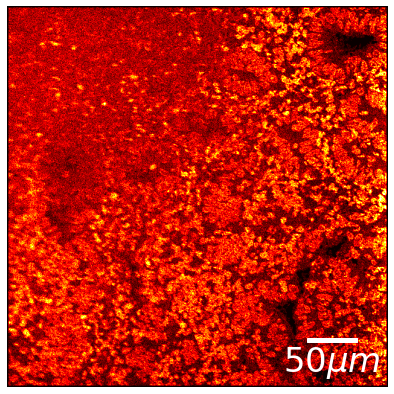

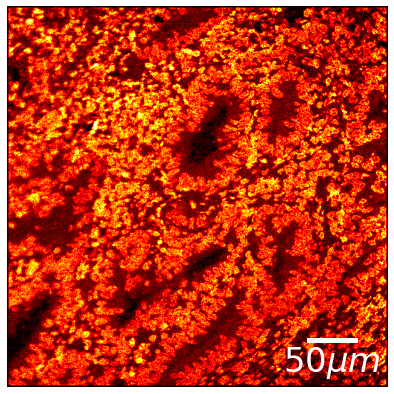

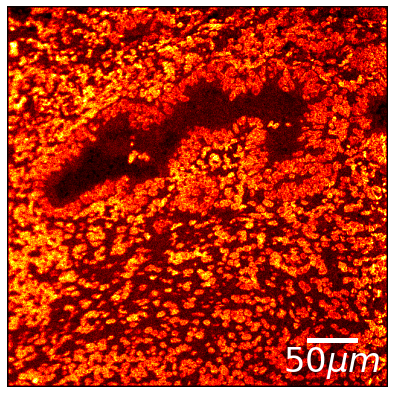

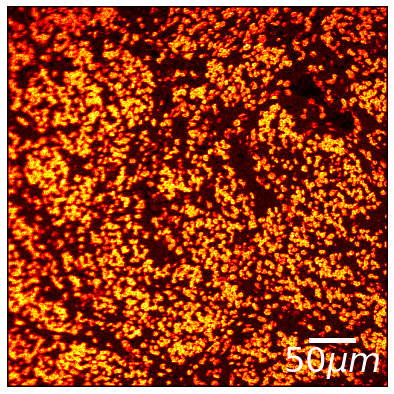

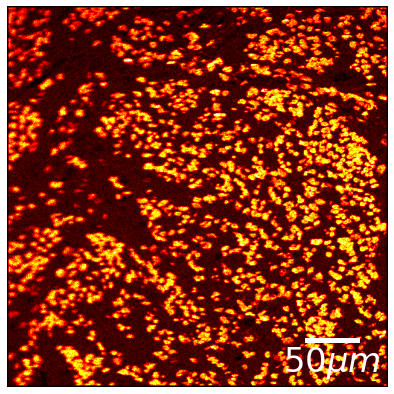

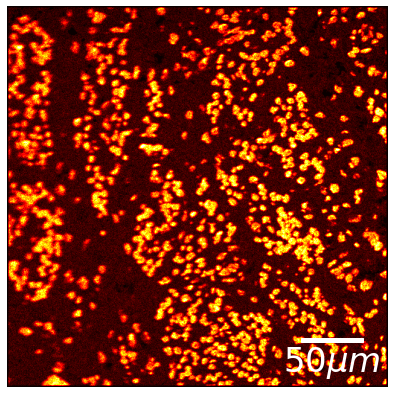

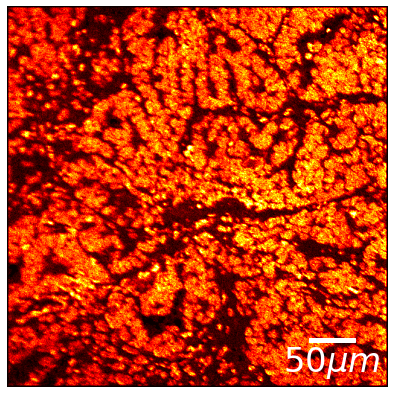

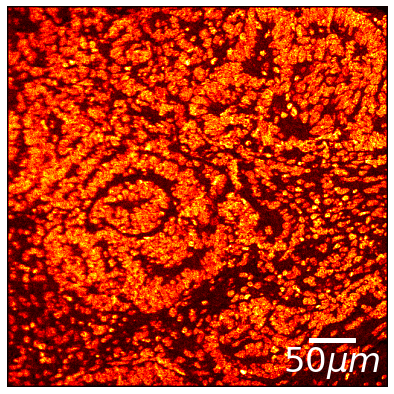

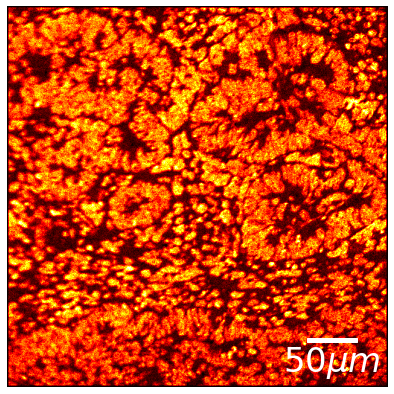

In [76]:
imgs_nuclei = []

for dataset in datasets:
    # Read images and get PO3 channel
    print(dataset)
    imgs, labels, fov = get_imgs(experiment, dataset)
    img_nuclei = get_imgs_index(imgs, [32, 18, 65, 55, 97, 73])
    # img_nuclei = get_imgs_index(imgs, [32, 18, 65])
    img_nuclei = contrast(img_nuclei)
    img_nuclei =  filter_img_knn(img_nuclei, th=2)
    size = imgs[0].shape[0]
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(img_nuclei, cmap='hot')
    ax.axis('off')
    scalebar = AnchoredSizeBar(ax.transData,
                           50/(fov/size), r'$50  \mu m$', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=5,
                           fontproperties=fontprops)
    ax.add_artist(scalebar)
    imgs_nuclei.append(img_nuclei)

# Segmentation

In [77]:
from skimage.segmentation import mark_boundaries
import skimage.io
from scipy.ndimage import distance_transform_edt

def save_mask(mask, folder, region):
    path = os.path.join(folder, f'{region}' + ".tif")
    skimage.io.imsave(path, mask)        

def expand_labels(label_image, distance=1):
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask]
        for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

In [78]:
from cellpose import models
from cellpose import utils

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='nuclei')

# Cyto segmentation
channels = [0,0]
masks, flows, styles, diams = model.eval(imgs_nuclei, diameter=7, flow_threshold=6.0, cellprob_threshold=-6.0, channels = channels, resample=False)

2022-01-24 16:15:42,088 [INFO] >>>> using CPU
2022-01-24 16:15:42,135 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
2022-01-24 16:15:42,136 [INFO] ~~~ FINDING MASKS ~~~
2022-01-24 16:22:58,064 [INFO] 100%|##########| 9/9 [07:15<00:00, 48.44s/it]
2022-01-24 16:22:58,064 [INFO] >>>> TOTAL TIME 435.93 sec


In [79]:
masks_expanded = []
for mask in masks:
    masks_expanded.append(expand_labels(mask, distance=1))

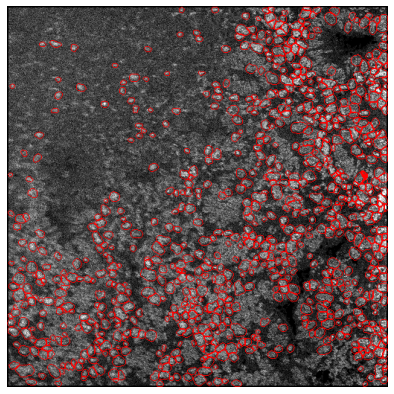

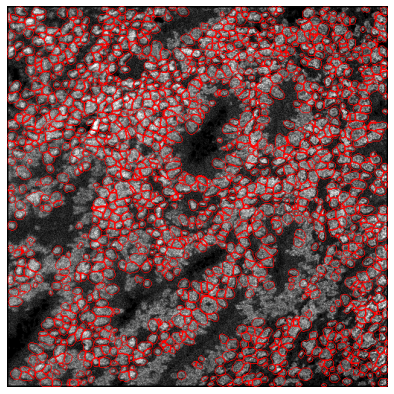

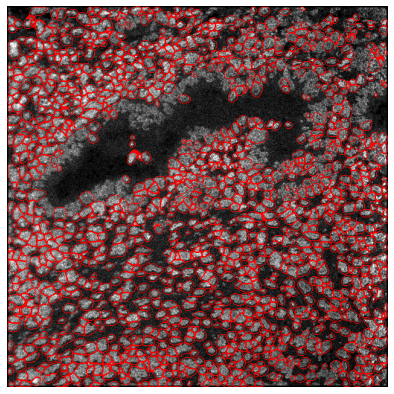

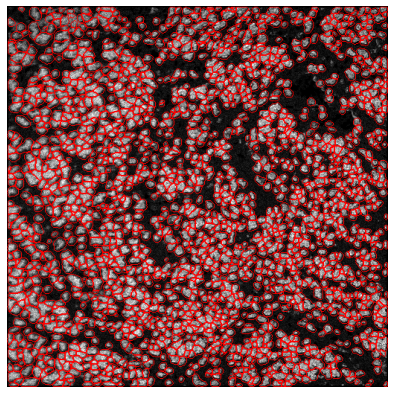

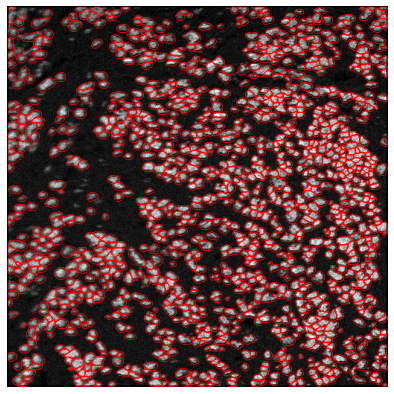

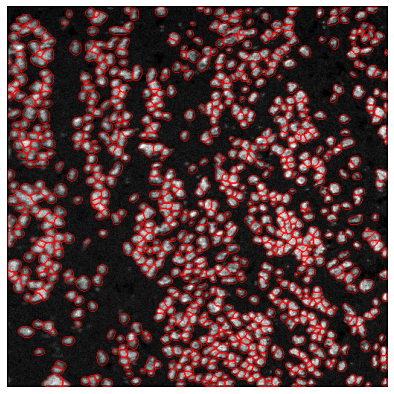

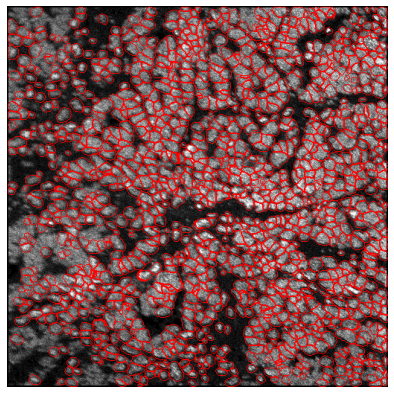

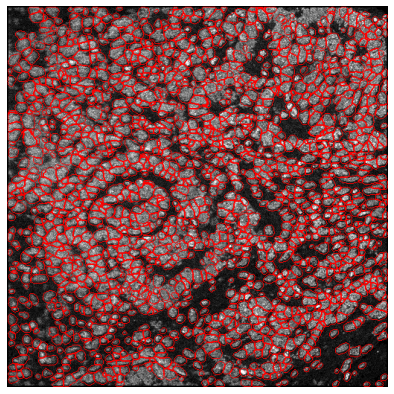

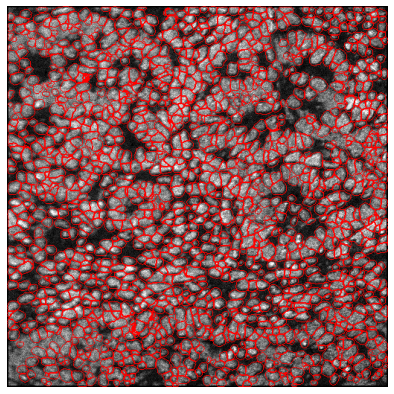

In [80]:
for i, mask in enumerate(masks):
    img_dapi = imgs_nuclei[i]
    
    img_bnd = mark_boundaries(img_dapi, mask, color=(1, 0, 0))
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(img_bnd, cmap = 'gray')
    ax.axis('off')

In [83]:
for i, dataset in enumerate(datasets):
    save_mask(masks_expanded[i], data_dir / 'masks', f'endometrium_{dataset}')

C:\Users\thu71\AppData\Local\Temp/ipykernel_103444/120315962.py:7: UserWarning: Y:\coskun-lab\Thomas\ScSpaMet\data\masks\endometrium_L11_1.tif is a low contrast image
  skimage.io.imsave(path, mask)
C:\Users\thu71\AppData\Local\Temp/ipykernel_103444/120315962.py:7: UserWarning: Y:\coskun-lab\Thomas\ScSpaMet\data\masks\endometrium_L11_2.tif is a low contrast image
  skimage.io.imsave(path, mask)
C:\Users\thu71\AppData\Local\Temp/ipykernel_103444/120315962.py:7: UserWarning: Y:\coskun-lab\Thomas\ScSpaMet\data\masks\endometrium_L11_3.tif is a low contrast image
  skimage.io.imsave(path, mask)
C:\Users\thu71\AppData\Local\Temp/ipykernel_103444/120315962.py:7: UserWarning: Y:\coskun-lab\Thomas\ScSpaMet\data\masks\endometrium_L128_1.tif is a low contrast image
  skimage.io.imsave(path, mask)
C:\Users\thu71\AppData\Local\Temp/ipykernel_103444/120315962.py:7: UserWarning: Y:\coskun-lab\Thomas\ScSpaMet\data\masks\endometrium_L128_2.tif is a low contrast image
  skimage.io.imsave(path, mask)
C:\